# Determining True Rating of Yelp Restaurants

Through data science analysis we aim to provide insight about the "true" rating of a restaraunt on Yelp. We define the "true" rating to be the rating that a restaurant will converge to over time based upon various features of the restaruant we have scraped from Yelp. This will be particularly useful for restuarants with few ratings that are curious as to what their true rating will be over time given features about their restaurant. Features used within our model include TODO

In [56]:
import requests
import copy
from bs4 import BeautifulSoup
import cPickle as pickle
import matplotlib.pyplot as plt
from yelp.client import Client
from yelp.oauth1_authenticator import Oauth1Authenticator
import folium

## Data Collection

We collected the dataset we plan on analyzing with the use of the Yelp API and Beautiful Soup. We also used Pickle to serialize our dataset so we don't have to continously query the Yelp API to get our data set. 

We first used the Yelp API to scrape at most 1000 restaurants (because of limitations of the Yelp API) from the top 280 cities in America (stores in cities.txt). We created functions for basic functionalities such as saving a pickle file, loading a pickle file, authenticating on Yelp, getting all restaurant info, getting all restaurants in a city, getting a list of all the top 280 cities, grabbing the relevant fields from each restaurant, cleaning the data, and finally a function to grab all the data using all the functions just described. 

In [4]:
def save_pickle(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
        
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def authenticate(config_filepath):
    creds = json.load(open(config_filepath))
    auth = Oauth1Authenticator(**creds)
    return Client(auth)

def yelp_search(client, query):
    res = client.search(query)
    return (res.total, res.businesses)

def all_restaurants(client, query, food):
    B = []
    while True:
        try:
            res = client.search(query,**{"category_filter":food,"offset" : len(B)})
            if not res.businesses:
                return B
            B += res.businesses
        except:
            return B

def get_cities_info(client, food, cities):
    d = {}
    for city in cities:
        print "requesting: ", city,
        d["%s_%s"%(city,food)] = all_restaurants(client,city,food)
        print ": done"
    valids = filter(lambda x: len(d[x]) >= 10, d)
    res = {v:d[v] for v in valids}
    return res

def get_all_cities():
    with open("cities.txt",'r') as f:
        lines = map(lambda l: ", ".join(l.rstrip().split("\t")[1:3]),f.readlines())
        return lines
    
def clean_business(b):
    valids = ["categories", "location", "name", "rating", "review_count","url"]
    return {x : b.__dict__[x] for x in valids} 
    
def clean_data(data):
    new_data = {}
    for city in data:
        new_data[city] = map(clean_business, data[city])
    return new_data
    
def get_data():
    client = authenticate("secret.json")
    cities = get_all_cities()
    data = get_cities_info(client, "restaurant", cities)
    data = clean_data(data)
    save_pickle("all_restaurants.pkl", data)
    
#get_data()

After the 

In [ ]:
def retrieve_html(url):
    html = requests.get(url)
    return (html.status_code, html.content)

""" Gets restaurant features from yelp html given a url for a restaurants page
    returns a dictionary of the available features on the page (keys) with their 
    corresponding values """
def scrapeYelpFeatures(url):
    (yolo, html) = retrieve_html(url)
    
    try:
        imgs =  re.search(r"See all [0-9]+", html).group()
        imgs = [int(s) for s in imgs.split() if s.isdigit()][0]
    except:
        imgs = 0
    root = BeautifulSoup(html, "html.parser")
    s = root.findAll("div", {'class' : 'ywidget'})
    
    biz_features = {"number_of_images" : imgs}
    for i in s:
        h3_elem = i.find("h3")
        if h3_elem != None:
            if 'More business info' in h3_elem:
                biz_attr = i.find('ul', {'class' : 'ylist'}).findAll('dt', {'class' : 'attribute-key'})
                biz_val = i.find('ul', {'class' : 'ylist'}).findAll('dd')

                for (l,r) in zip(biz_attr, biz_val):
                    biz_features[l.next_element.strip()] = r.next_element.strip()
    return biz_features

def add_feature_info(data, offset):
    c = offset+1
    for d in data[offset:]:
        print "%d of %d"%(c,len(data))
        features = scrapeYelpFeatures(d["url"])
        d.update(features)
        c += 1
        
def get_feature_set(datalist):
    features = set()
    for f in datalist:
        features |= set(f)
    return features

def fix_features(datalist):
    features = get_feature_set(datalist)
    for d in datalist:
        for f in features:
            if f not in d:
                d[f] = None

def get_random_data(data, n):
    datalist = []
    for d in data:
        datalist += data[d]
    return random.sample(datalist,n)

## Data Processing

After we cleaned our dataset, we begin processing the data. We 

In [54]:
data = load_pickle("random.pkl")

# Input is a list of dictionarys mapping features to values (defined in pickle) 
def transform_to_XY(info):
    X = []
    Y = []
    feature_names = [i for i in info[0].keys()]
    total_vals = {}
    for x in feature_names:
        total_vals[x] = set()
    
    to_ignore = set(['name', 'rating', 'location', 'categories', 'url', 'parking', 'Best Nights','Good For'])
    
    for res in info:
        for k,v in res.items():
            if k not in to_ignore: # Some features are of list type or already floats, or not primitive types
                total_vals[k].add(v)
    
    #print total_vals
    feature_value_map = {}
    for k,v in total_vals.items():
        z = 0
        feature_value_map[k] = {}
        for value in v:
            feature_value_map[k][value] = z
            z += 1
            
    features = copy.deepcopy(info)
    nones = []
    for b in features:
        b["nones"] = sum([1 if b[f] == None else 0 for f in b])
        nones.append(44 - b["nones"])
        for f in to_ignore:
            b.pop(f, None)
        for f in b:
            if f not in to_ignore and f in feature_value_map and b[f] in feature_value_map[f]:
                if f not in ["review_count",'number_of_images']:
                    b[f] = feature_value_map[f][b[f]]
    features = [[d[f] for f in sorted(d.keys())] for d in features]
    return (features, [f["rating"]*2 for f in info], nones)

transformed = transform_to_XY(data)

## Data Exploration and Visualization

Our final data set has a total of 6308 restaurants that were randomly sampled from our much larger data set of 1000 restaurants from each of the top 280 cities in the United States.

We will now explore and visualize this dataset.

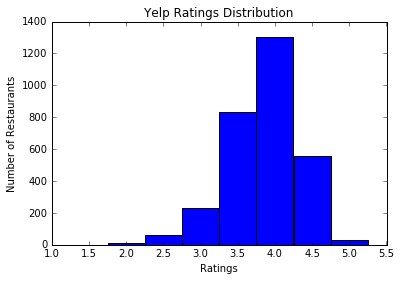

In [97]:
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

number_of_reviews = []
for i in xrange(len(data)):
    if (data[i]["review_count"] >= 50):
        number_of_reviews.append(data[i]["rating"])
        
ratings = Counter(number_of_reviews)
rating_numbers = sorted(ratings)
rating_counts = []
for i in xrange(len(rating_numbers)):
    rating_counts.append(ratings[rating_numbers[i]])
plt.bar(rating_numbers, rating_counts, 0.5, color="blue", align = "center")
plt.xlabel("Ratings")
plt.ylabel("Number of Restaurants")
plt.title("Yelp Ratings Distribution")
plt.show()

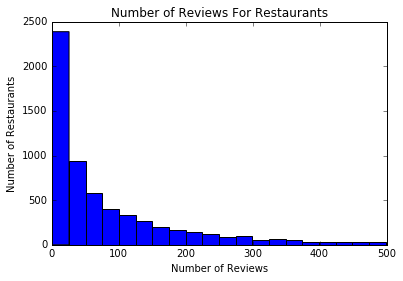

In [37]:
number_of_reviews = []
for i in xrange(len(data)):
    if (data[i]["review_count"] < 500):
        number_of_reviews.append(data[i]["review_count"])
plt.hist(number_of_reviews, 20)
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Restaurants")
plt.title("Number of Reviews For Restaurants")
plt.show()

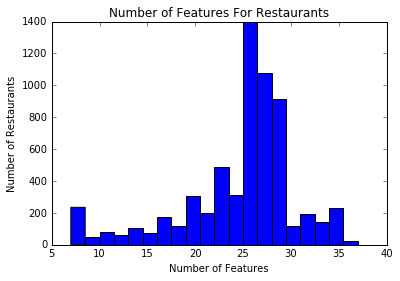

In [55]:
plt.hist(transformed[2], 20)
plt.xlabel("Number of Features")
plt.ylabel("Number of Restaurants")
plt.title("Number of Features For Restaurants")
plt.show()

In [92]:
locations = []
for i in xrange(len(data)):
    if data[i]["location"] != None and data[i]["location"].coordinate != None:
        locations.append((data[i]["location"].coordinate.__dict__["latitude"], 
                          data[i]["location"].coordinate.__dict__["longitude"]))

USMap = folium.Map(location=[39.8282, -98.5795], zoom_start = 4)
for location in locations:
    latitude = float(location[0])
    longitude = float(location[1])
    folium.CircleMarker(location=[latitude, longitude], radius=10, color='#3186cc', fill_color='#3186cc').add_to(USMap)
USMap.save("locations.html")

## Data Analysis

We will be focusing on determining an adaquate normalization technique.

In [98]:
import cPickle as pickle
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from collections import Counter
import sklearn.cross_validation as cv
import random
import numpy as np
from copy import deepcopy

In [103]:
def accuracy(svm, X, y):
    preds = svm.predict(X)
    print Counter(preds)
    wrong = 0
    dist = 0
    for (p,l) in zip(preds,y):
        if int(p) != int(l):
            wrong += 1
            dist += abs(l-p)/2.0
    print "correct predictions: %f%%"%((len(y)-wrong)/float(len(y)))
    print "average error: %f"%(dist/wrong)

def cross_val(model, folds):
    (X, y) = transform_to_XY(infotrain)
    pca = PCA(n_components='mle')
    pca.fit(X)
    X = pca.transform(X)
    scores = cv.cross_val_score(model,X,y, cv = folds)
    print "Accuracy: %0.2f" %scores.mean()
    

In [105]:
infotrain = filter(lambda x: x["review_count"] > 50, data)
cross_val(RandomForestClassifier(n_estimators=100),5)

ValueError: too many values to unpack

## Results and Conclusions

We will be using the map library Folium to visualize our results and make some final conclusions.